In [12]:
import numpy as np
import math as math
import matplotlib.pyplot as plt

#loading data

train_s = np.load('hw2_material/knn/train_set.npy')
train_l = np.load('hw2_material/knn/train_labels.npy')

test_set = np.load('hw2_material/knn/test_set.npy') 
test_labels = np.load('hw2_material/knn/test_labels.npy')

In [2]:
def calculate_distances(train_data, test_instance, distance_metric):
    """
    Calculates Manhattan (L1) / Euclidean (L2) distances between test_instance and every train instance.
    :param train_data: An (N, D) shaped numpy array where N is the number of examples
    and D is the dimension of the data.
    :param test_instance: A (D, ) shaped numpy array.
    :param distance_metric: A string which indicates the distance metric, it can be either 'L1' or 'L2'
    :return: An (N, ) shaped numpy array that contains distances.
    """
    distances = np.empty(0)
    
    if(distance_metric == 'L1'):
        for train_instance in train_data:
            a, b, c, d = train_instance
            e, f, g, h = test_instance
            distance = abs(a-e) + abs(b-f) + abs(c-g) + abs(d-h)
            distances = np.append(distances, distance)
        
    elif(distance_metric == 'L2'):
        for train_instance in train_data:
            a, b, c, d = train_instance
            e, f, g, h = test_instance
            distance = math.sqrt(pow(a-e, 2) + pow(b-f, 2) + pow(c-g, 2) + pow(d-h, 2))
            distances = np.append(distances, distance)
    
    return distances
    

In [3]:
def majority_voting(distances, labels, k):
    """
    Applies majority voting. If there are more then one major class, returns the smallest label.
    :param distances: An (N, ) shaped numpy array that contains distances
    :param labels: An (N, ) shaped numpy array that contains labels
    :param k: An integer. The number of nearest neighbor to be selected.
    :return: An integer. The label of the majority class.
    """
    
    smallest_distance_index = 0
    smallest_distance = distances[0]
    prev_smallest_distance_index = -1
    j=0
    
    neighbours_classes = np.empty(0)
    
    for i in range(k):
        for distance in distances:  #finding the smallest distances while making sure not the same distances are selected over and over again
            if(j != prev_smallest_distance_index):
                if(prev_smallest_distance_index != -1):
                    if(distance > distances[prev_smallest_distance_index]):
                        if(distance < smallest_distance):
                            smallest_distance = distance
                            smallest_distance_index = j
                elif(distance < smallest_distance):
                    smallest_distance = distance
                    smallest_distance_index = j
            j+=1
        
        neighbours_classes = np.append(neighbours_classes, labels[smallest_distance_index])  #making array of neighbours classes
        prev_smallest_distance_index = smallest_distance_index
        smallest_distance_index = 0
        smallest_distance = distances[0]
        j=0
        
    neighbours_classes = np.sort(neighbours_classes)
    current_label = neighbours_classes[0]
    smallest_label = neighbours_classes[0]
    smallest_label_total = 0
    current_label_total = 0
    
    
    for label in neighbours_classes:  #finding smallest majority class in the neighbors classes
        if(label == current_label):
            current_label_total += 1
            if(current_label_total > smallest_label_total):
                smallest_label = current_label
                smallest_label_total = current_label_total
        elif(current_label_total > smallest_label_total):
            smallest_label = current_label
            smallest_label_total = current_label_total
            current_label = label
            current_label_total = 1
        elif(current_label_total == smallest_label_total):
            if(current_label < smallest_label):
                smallest_label = current_label
            current_label = label
            current_label_total = 1
        
    return smallest_label
    

In [4]:
def knn(train_data, train_labels, test_data, test_labels, k, distance_metric):
    """
    Calculates accuracy of knn on test data using train_data.
    :param train_data: An (N, D) shaped numpy array where N is the number of examples
    and D is the dimension of the data
    :param train_labels: An (N, ) shaped numpy array that contains labels
    :param test_data: An (M, D) shaped numpy array where M is the number of examples
    and D is the dimension of the data
    :param test_labels: An (M, ) shaped numpy array that contains labels
    :param k: An integer. The number of nearest neighbor to be selected.
    :param distance_metric: A string which indicates the distance metric, it can be either 'L1' or 'L2'
    :return: A float. The calculated accuracy.
    """
    
    total_guesses = 0
    correct_guesses = 0
    i=0
    
    for test_instance in test_data:  #calculating average accuracy over each test instance
        distances_array = calculate_distances(train_data, test_instance, distance_metric)
        major_class = majority_voting(distances_array, train_labels, k)
        if(major_class == test_labels[i]):
            correct_guesses+=1
        total_guesses+=1
        i+=1

    return(correct_guesses/total_guesses)
    

In [5]:
def split_train_and_validation(t_data, t_labels, validation_index, k_fold):
    """
    Splits training dataset into k and returns the validation_indexth one as the
    validation set and others as the training set. You can assume k_fold divides N.
    :param whole_train_data: An (N, D) shaped numpy array where N is the number of examples
    and D is the dimension of the data
    :param whole_train_labels: An (N, ) shaped numpy array that contains labels
    :param validation_index: An integer. 0 <= validation_index < k_fold. Specifies which fold
    will be assigned as validation set.
    :param k_fold: The number of groups that the whole_train_data will be divided into.
    :return: train_data, train_labels, validation_data, validation_labels
    train_data.shape is (N-N/k_fold, D).
    train_labels.shape is (N-N/k_fold, ).
    validation_data.shape is (N/k_fold, D).
    validation_labels.shape is (N/k_fold, ).
    """
    whole_train_data = t_data
    whole_train_labels = t_labels
    
    whole_train_data = whole_train_data.reshape(k_fold, whole_train_data.size//k_fold)  #reshaping so that each row is a k fold
    whole_train_labels = whole_train_labels.reshape(k_fold, whole_train_labels.size//k_fold)  #same reason as above
    
    val_set = whole_train_data[validation_index]  #getting the validation data
    val_labels = whole_train_labels[validation_index]   #getting the validation labels
    
    whole_train_data = np.delete(whole_train_data, validation_index, axis=0)   #deleting the validation data from the train data
    whole_train_labels = np.delete(whole_train_labels, validation_index, axis=0)  #deleting the validation labels from the train labels
    whole_train_data = whole_train_data.reshape(whole_train_data.size//4, 4)  #back to original shape but with less data as some of it deleted
    whole_train_labels = whole_train_labels.flatten()  #same reason as above
    val_set = val_set.reshape(val_set.size//4, 4)  #reshaping to the required shape
    val_labels = val_labels.flatten()
    
    return whole_train_data, whole_train_labels, val_set, val_labels
    

In [6]:
def cross_validation(whole_train_data, whole_train_labels, k_fold, k, distance_metric):
    """
    Applies k_fold cross-validation and averages the calculated accuracies.
    :param whole_train_data: An (N, D) shaped numpy array where N is the number of examples
    and D is the dimension of the data
    :param whole_train_labels: An (N, ) shaped numpy array that contains labels
    :param k_fold: An integer.
    :param k: An integer. The number of nearest neighbor to be selected.
    :param distance_metric: A string which indicates the distance metric, it can be either 'L1' or 'L2'
    :return: A float. Average accuracy calculated.
    """
    accuracies_total = 0
    
    for i in range(k_fold):
        td, tl, vd, vl = split_train_and_validation(whole_train_data, whole_train_labels, i, k_fold)
        accuracies_total += knn(td, tl, vd, vl, k, distance_metric)
    
    return (accuracies_total/k_fold)
    

In [7]:
distance_metrics = ['L1','L2']

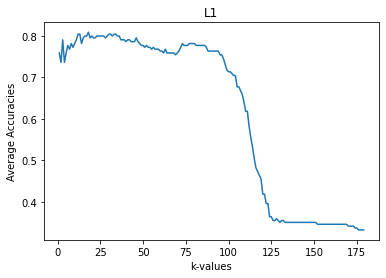

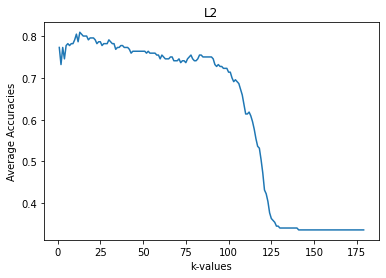

highest accuracy, metric, k
0.8090909090909092 L2 13


In [18]:
highest_accuracy = 0
ha_k = 0
ha_metric = 'L1'
k_values = np.empty(0)
accuracies = np.empty(0)
for i in range(1, 180):
    k_values = np.append(k_values, i)

for metric in distance_metrics:
    for k in range(1, 180):
        #print(k)
        accuracy = cross_validation(train_s, train_l, 10, k, metric)
        accuracies = np.append(accuracies, accuracy)
        #print(f'Distance Metric = {metric} | K = {k} | Accuracy = {accuracy * 100}%\n')
        if(accuracy > highest_accuracy):
            highest_accuracy = accuracy
            ha_k = k
            ha_metric = metric
    plt.plot(k_values, accuracies)
    plt.xlabel('k-values')
    plt.ylabel('Average Accuracies')
    if(metric == 'L1'):
        plt.title('L1')
    else:
        plt.title('L2')
    plt.show()
    accuracies = np.empty(0)

print("highest accuracy, metric, k")
print(highest_accuracy,ha_metric,ha_k)
        

In [20]:
test_accuracy = knn(train_s, train_l, test_set, test_labels, 13, 'L2')
print(f'Test Accuracy on best distance metric and k value: {test_accuracy}')

Test Accuracy on best distance metric and k value: 0.8055555555555556
